In [1]:
from google.colab import output   

In [2]:
!pip install iterative-stratification
!pip install -U fastai
!pip install timm
output.clear()

In [3]:
import os
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer
from torch.distributions.beta import Beta
from PIL import ImageFile
import zipfile
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
!unzip /content/drive/MyDrive/set_raw.zip
output.clear()

In [5]:
df_path = '/content/drive/MyDrive/raw_image.csv'
img_path = '/content/set_raw/'
df = pd.read_csv(df_path)
df['Image'] = df['Image'].apply(lambda x: img_path + x + '.png')
df.head()

,Image,labels
0,/content/set_raw/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0.png,0|5|8
1,/content/set_raw/5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0.png,0|14
2,/content/set_raw/60b57878-bb99-11e8-b2b9-ac1f6b6435d0.png,1|6
3,/content/set_raw/5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0.png,10|16
4,/content/set_raw/5b931256-bb99-11e8-b2b9-ac1f6b6435d0.png,0|14


In [6]:
single_labels = [str(i) for i in range(19)]

for label in single_labels:
    df[label] = df['labels'].apply(lambda r: int(label in r.split('|')))
    
df.head()

,Image,labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,/content/set_raw/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0.png,0|5|8,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,/content/set_raw/5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0.png,0|14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,/content/set_raw/60b57878-bb99-11e8-b2b9-ac1f6b6435d0.png,1|6,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,/content/set_raw/5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0.png,10|16,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,/content/set_raw/5b931256-bb99-11e8-b2b9-ac1f6b6435d0.png,0|14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [7]:
X = df['Image']
y = df[single_labels]
df['fold'] = np.nan

In [8]:
mskf = MultilabelStratifiedKFold(n_splits = 10, shuffle = False)

for i, (_, test_index) in enumerate(mskf.split(X, y)):
    df.iloc[test_index, -1] = i
    
df['fold'] = df['fold'].astype(int)

In [9]:
df['valid'] = df['fold'].apply(lambda x: x == 0)
train_df = df[['Image', 'labels', 'valid']]
train_df['labels'] = train_df['labels'].astype(str)
train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Image,labels,valid
0,/content/set_raw/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0.png,0|5|8,False
1,/content/set_raw/5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0.png,0|14,False
2,/content/set_raw/60b57878-bb99-11e8-b2b9-ac1f6b6435d0.png,1|6,True
3,/content/set_raw/5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0.png,10|16,False
4,/content/set_raw/5b931256-bb99-11e8-b2b9-ac1f6b6435d0.png,0|14,False
...,...,...,...
26469,/content/set_raw/15_B9_2.png,18,False
26470,/content/set_raw/1657_F11_2.png,18,False
26471,/content/set_raw/1606_C7_1.png,18,False
26472,/content/set_raw/1703_D3_2.png,18,False


In [10]:
def get_image_path(x): return x.Image

In [11]:
item_tfms = Resize(448, method = 'squish')
batch_tfms = [Rotate(max_deg = 270, p = 0.9), Normalize()]
bs = 32

In [12]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock(vocab = single_labels)),
                splitter = ColSplitter(col='valid'),
                get_x = get_image_path,
                get_y = ColReader('labels', label_delim = '|'),
                item_tfms = item_tfms,
                batch_tfms = batch_tfms)

dls = dblock.dataloaders(train_df, bs = bs)

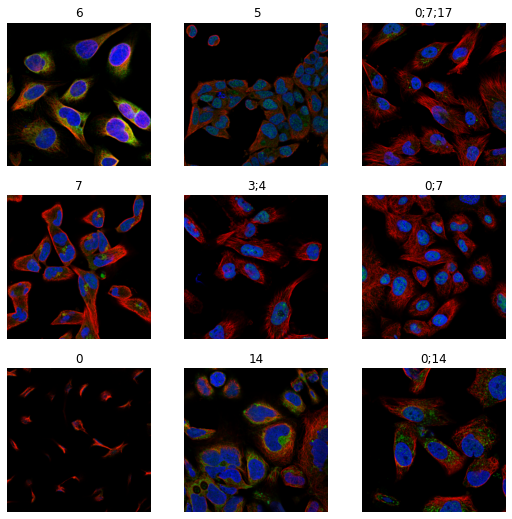

In [13]:
dls.show_batch(nrows = 3, ncols = 3)

In [14]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [15]:
model_name = 'efficientnet_b3'
lr = 1e-2
epochs = 8

In [16]:
learn = timm_learner(dls = dls, arch = model_name, metrics = [accuracy_multi, PrecisionMulti()],
                     cbs = SaveModelCallback(fname = '{}'.format(model_name))).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [17]:
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.215362,0.198132,0.931623,0.640583,07:12
1,0.156344,0.153363,0.943060,0.742254,07:09
2,0.146465,0.143916,0.946080,0.768580,07:10
3,0.134599,0.124880,0.954899,0.836539,07:10
4,0.128675,0.122444,0.955684,0.875503,07:10
5,0.118729,0.115657,0.957234,0.806505,07:10
6,0.116715,0.112164,0.958603,0.850933,07:10
7,0.108327,0.111811,0.958926,0.847115,07:10


Better model found at epoch 0 with valid_loss value: 0.19813185930252075.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with valid_loss value: 0.15336257219314575.
Better model found at epoch 2 with valid_loss value: 0.14391636848449707.
Better model found at epoch 3 with valid_loss value: 0.12488012760877609.
Better model found at epoch 4 with valid_loss value: 0.12244395166635513.
Better model found at epoch 5 with valid_loss value: 0.11565686017274857.
Better model found at epoch 6 with valid_loss value: 0.11216379702091217.
Better model found at epoch 7 with valid_loss value: 0.11181094497442245.
